# Action1_pytorch_cifar10_accuracy%96

In [5]:
# 挂载colab，路径定位
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Bi-IV/CNN")

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader

In [6]:
pwd

'/content/drive/My Drive/Colab Notebooks/Bi-IV/CNN'

In [9]:
# 数据加载
train_data = datasets.CIFAR10(root='./',train=True, transform=transforms.ToTensor()) #  download=True
test_data = datasets.CIFAR10(root='./',train=False, transform=transforms.ToTensor())

In [90]:
# 50000训练图片，10000测试图片
train_data.data.shape,test_data.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

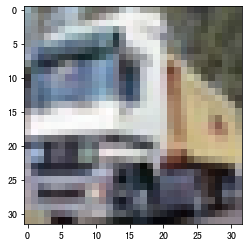

In [95]:
plt.imshow(train_data.data[1])

(3, 32, 32)
(32, 32, 3)


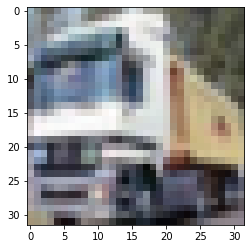

In [10]:
# 输出图像
temp = train_data[1][0].numpy()
print(temp.shape)
temp = temp.transpose(1, 2, 0) # 调换temp.shape的三个维度0，1，2位置
print(temp.shape)
plt.imshow(temp)

In [17]:
# 超参数定义
EPOCH = 10
BATCH_SIZE = 128
LR = 0.001

# 使用DataLoader进行分批
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE) # 没有shuffle，因为不进行训练

# 使用ResNet
model = torchvision.models.resnet18(pretrained=True) # 预训练,models注意有s


In [12]:
torch.cuda.is_available()

True

In [19]:
# 定义损失函数为交叉熵，二分类常用损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器为adam，引入二阶动量
optimizer = optim.Adam(model.parameters(), lr=LR)

# 定义device  gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# 训练，google GPU，每个epoch比cpu快了3.5倍
for epoch in range(EPOCH):
    start_time = time.time()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # 如果有gpu将数据放到gpu里
        # 前向传播
        outputs = model(inputs)
        # 计算损失函数
        loss = criterion(outputs, labels)
        # 清空上一轮梯度
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 知道梯度方向以后，参数更新
        optimizer.step()
    print('epoch{} loss:{: .4f} time{: .4f}'.format(epoch+1, loss.item(), time.time()-start_time))

epoch1 loss: 0.8631 time 20.5853
epoch2 loss: 0.5325 time 20.7143
epoch3 loss: 0.5892 time 20.9142
epoch4 loss: 0.3453 time 21.0151
epoch5 loss: 0.2485 time 21.0880
epoch6 loss: 0.3284 time 21.0842
epoch7 loss: 0.3116 time 21.0700
epoch8 loss: 0.2450 time 21.0525
epoch9 loss: 0.3559 time 21.0755
epoch10 loss: 0.2687 time 21.0728


In [21]:
# 保存训练模型
file_name = 'cifar10_resnet_colab_epoch10.pt'
torch.save(model, file_name)
print(file_name + ' saved ')

cifar10_resnet_colab_epoch10.pt saved 


In [22]:
# 测试
model = torch.load(file_name)
model.eval()# 不启用 BatchNormalization 和 Dropout,固定BN和dropout层，使得偏置参数不随着发生变化。因为当batchsize小时，如果没有固定，会对图像的失真有很大的影响

correct, total = 0, 0
for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    # 前向传播
    out = model(images)
    # 预测结果
    _, predicted = torch.max(out.data, 1)
    # 判断预测结果与实际结果是否一致
    total += labels.size(0)
    correct += (predicted==labels).sum().item()
    
# 输出识别准确率
print('10000张测试图像的准确率：{: .4f}'.format(100*correct/total))

10000张测试图像的准确率： 96.6120


In [103]:
# values是给定维中的每行张量的最大值；indices是找到的每个最大值的索引位置。
# 最大值相当于softmax的概率最大的位置的索引，就是分类的标签
torch.max(out.data,1)

torch.return_types.max(
values=tensor([10.5876, 13.8441,  9.7160, 13.9375, 21.3442, 12.6578, 17.7501, 12.2050,
        16.3147, 13.3066, 14.7981, 12.0003, 11.9597, 17.4236, 12.1771, 15.5576]),
indices=tensor([7, 5, 8, 0, 8, 4, 7, 0, 3, 3, 3, 0, 3, 5, 0, 7]))